# Exploring the Relationship Between Reddit Sentiment and Stock Price Movements
## 1. Introduction & Hypothesis
**Business/Research Question**  
Can the sentiment in stock-related Reddit posts be used to predict short-term stock price movements?

This project conducts an empirical investigation into the relationship between social media sentiment and financial markets.
It aims to determine if a statistically significant correlation exists between online discourse and stock performance, by analyzing one year of posts from finance and stock focused subreddits concerning three major tech stocks - NVIDIA, Tesla, and Google.

**Initial Hypothesis**  
There will be a statistically significant positive correlation between weekly sentiment scores and weekly stock returns.

## 2. Methodology Overview
To test this hypothesis, the project will:

1. **Collect Data:**  
   Gather historical stock price data for NVDA, TSLA, and GOOGL and scrape Reddit posts mentioning these stocks from relevant subreddits over the same time period.  
2. **Process Data:**  
   - Clean the text data and calculate sentiment scores for individual Reddit posts using two distinct NLP libraries: **TextBlob** and **VADER**
   - Calculate weekly stock returns from price data
   - Aggregate post-level sentiment to weekly averages
   - Merge weekly sentiment and stock return datasets  
3. **Analyze & Visualize:**  
   Employ descriptive statistics, visualizations, and correlation analysis to explore the relationship between weekly sentiment and stock returns.  
4. **Critically Assess:**  
   Evaluate the strength, significance, and practical importance of any found relationships, and discuss methodological limitations.

### 2.1 Data Source Justification
**A. Subreddit Selection**  
Data was scraped from a curated list of finance-focused communities:
    "r/wallstreetbets", "r/stocks", "r/investing", "r/StockMarket", and "r/StocksAndTrading".
* **Inclusion Justification**  
These subreddits were chosen because their primary purpose is the discussion of stocks and investing. This focus provides a direct pipeline to potential market sentiment, as opposed to general news or technology forums where discussion may not be investment-oriented.
* **Exclusion Justification**  
Highly specialized subreddits like "r/Options" (focused on short-term, tactical options trading) and "r/SecurityAnalysis" (focused on long-term, fundamental valuation) were excluded.
While relevant to finance, their highly specific contexts and investment horizons would introduce distinct, competing signals, complicating the goal of capturing a broader, more general measure of retail investor sentiment.
* **Bias Acknowledgment**  
It is recognized that the selected subreddits represent a spectrum of investor psychologies (e.g. the speculative nature of "r/wallstreetbets" vs. the long-term focus of "r/investing"). This internal variation is a noted characteristic of the dataset.

**B. Stock Selection**  
The analysis focuses on three stocks: **NVIDIA (NVDA)**, **Tesla (TSLA)**, and **Alphabet (GOOGL)**.  
These companies were selected based on three key criteria:
1.  **High Profile & Discussion Volume**  
       They are among the most discussed companies on social media and financial news, ensuring a sufficient volume of Reddit posts for a robust analysis.
2.  **Significant Volatility**  
       Both NVDA and TSLA have historically shown significant price volatility. GOOGL provides a slightly more stable counterpoint. This mix is ideal for testing if sentiment correlates with price movements, as volatile stocks have more "signal" to detect.
3.  **Diversity within Tech**  
       While all are in the technology sector, they represent different sub-sectors (semiconductors, electric vehicles/clean energy, internet services/ads), allowing for a more nuanced exploration of whether the sentiment relationship holds across different business models.

**C. Timeframe Justification**  
The analysis covers a one-year historical period. This timeframe was primarily determined by a practical constraint: the Reddit API (via the PRAW library) allows for the efficient extraction of posts from up to one year in the past. To ensure a synchronized analysis, the stock price data was collected for the identical one-year window. This provides a balanced dataset with approximately 52 weekly observations for each stock, which is sufficient for a robust correlation analysis while respecting data collection limits.

### 2.2 Success Criteria
The project will be considered successful if it can:
*   **Quantify the Relationship**  
  Identify a statistically significant correlation coefficient between weekly aggregated sentiment scores and weekly stock returns.
*   **Critically Evaluate the Findings**  
  Provide a reasoned discussion on the practical significance (or lack thereof) of any correlation found, acknowledging confounding factors and the fundamental difference between correlation and causation.

### 2.3 Temporal Aggregation Strategy

The relationship between sentiment and stock returns may vary across different time horizons. After considering daily and weekly alternatives, weekly aggregation was selected for this analysis:

*   **Analysis Approach: Weekly Aggregation**
    *   Reddit posts will be aggregated by trading week (Friday-to-Friday) to calculate a **weekly average sentiment score**.
    *   Stock prices will be used to calculate **weekly percentage returns** (using the closing price on Friday vs. the previous Friday).
    *   **Justification:** This approach smooths out the high noise of daily fluctuations while still capturing the relatively fast-moving nature of social media sentiment. It provides a robust number of data points (~52 weeks) for statistical testing while mitigating the impact of intra-week volatility and timing issues associated with daily analysis.

#### 2.4 Initial Considerations and Limitations
Before beginning the analysis, it is crucial to acknowledge key limitations that frame our interpretation of the results:

* **Correlation vs. Causation**  
  This study can identify a correlation, but it cannot prove causation. A positive relationship does not mean Reddit sentiment causes stock price moves. The reverse could be true (price moves influence sentiment), or both could be driven by an external factor like news events.

* **Confounding Variables**  
  Stock prices are influenced by countless factors (e.g., earnings reports, economic data, geopolitical events). Our analysis, which only looks at sentiment, will not account for these, which is a significant limitation.

* **Sample Bias**  
  The sentiment is derived only from Reddit users, who are not representative of the entire market of investors. The findings are specific to this population and platform.

This focused approach ensures methodological consistency between hypothesis testing and data analysis.

## 3. Packages Installation and Imports

**Note:** The following cell installs the necessary Python packages. This is only required once per runtime environment.

In [1]:
# Install required packages
!pip install yfinance pandas numpy matplotlib seaborn vaderSentiment textblob python-dotenv statsmodels praw

In [51]:
# Utils
import os
import numpy as np
import pandas as pd
from scipy.stats import skew
from dotenv import load_dotenv
from datetime import datetime, timedelta

# APIs & Web
import praw
import yfinance as yf

# NLP & Sentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Jupyter Notebook Magic for inline plots
%matplotlib inline

load_dotenv() # Loads REDDIT_CLIENT_ID, REDDIT_CLIENT_SECRET, REDDIT_USER_AGENT

True

## 4. Data Collection & Preparation

This section implements the data collection pipeline described in Section 2, gathering and preparing both stock market data and Reddit sentiment data for correlation analysis.

### 4.1 Stock Data Collection

In [81]:
# Configuration
data_dir = "./data"

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

stock_tickers = ["NVDA", "TSLA", "GOOGL"]

def stock_data_loader(use_saved=True, tickers=stock_tickers):
    """
    Loads or downloads stock price data for a list of tickers.
    
    Args:
        use_saved (bool): If True, attempts to load data from CSV files.
        tickers (list): List of stock ticker symbols.
        
    Returns:
        tuple: 
            - dict: Dictionary with tickers as keys and DataFrames as values
            - bool: True if saved data was used, False if fresh download was performed
    """
    stock_data = {}
    
    if use_saved:
        print("Attempting to load saved data...")
        all_files_exist = all(os.path.exists(os.path.join(data_dir, f"stock_data_{ticker}.csv")) for ticker in tickers)
        
        if all_files_exist:
            for ticker in tickers:
                try:
                    # Load the CSV
                    file_path = os.path.join(data_dir, f"stock_data_{ticker}.csv")
                    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
                    
                    stock_data[ticker] = df
                    print(f"✓ Loaded data for {ticker} (Shape: {df.shape})")
                    
                except Exception as e:
                    print(f"✗ Loading stock data for {ticker} failed: {e}")
                    return stock_data_loader(use_saved=False, tickers=tickers)
            return stock_data, True
        else:
            print("Saved data not found for all tickers. Downloading fresh data...")
    
    # Download fresh data
    print("Downloading fresh data...")
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    
    for ticker in tickers:
        try:
            # Download data
            # auto_adjust=True ensures prices are adjusted for splits and dividends
            df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
            if df.empty:
                print(f"✗ No data downloaded for {ticker}")
                continue

            # yf.download returns MultiIndex DataFrame even for a single ticker.
            # droplevel(1) removes redundant ticker name from the columns
            df.columns = df.columns.droplevel(1)
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Ensure consistent column order
            
            stock_data[ticker] = df
            print(f"✓ Downloaded data for {ticker} (Shape: {df.shape})")
            
            # Save the DataFrame
            file_path = os.path.join(data_dir, f"stock_data_{ticker}.csv")
            df.to_csv(file_path, index_label='Date')
            print(f"  Saved to {file_path}")
            
        except Exception as e:
            print(f"✗ Downloading stock data for {ticker} failed: {e}")
    
    return stock_data, False

stock_data, used_saved = stock_data_loader()
print(f"\nData ready! Source: {'saved files' if used_saved else 'fresh download'}")
print("\nData Validation:")
for ticker, data in stock_data.items():
    print(f"  {ticker}: {len(data)} days, {data.index.min().date()} to {data.index.max().date()}")

Attempting to load saved data...
✓ Loaded data for NVDA (Shape: (251, 5))
✓ Loaded data for TSLA (Shape: (251, 5))
✓ Loaded data for GOOGL (Shape: (251, 5))

Data ready! Source: saved files

Data Validation:
  NVDA: 251 days, 2024-10-28 to 2025-10-28
  TSLA: 251 days, 2024-10-28 to 2025-10-28
  GOOGL: 251 days, 2024-10-28 to 2025-10-28


### 4.2 Reddit Data Collection

**Reddit Data Sampling Strategy**  
Reddit posts are collected via the PRAW library.
By setting sort="top" and time_filter="year", the most upvoted posts from the past year that match the keywords are collected.

Rationale:  
This approach prioritizes impactful discourse. Highly upvoted posts represent sentiment seen and endorsed by a larger portion of the subreddit community, which is a stronger signal of collective sentiment than a simple chronological feed which would be dominated by low-engagement posts.

In [168]:
stock_keywords = {
    'NVDA': ['nvidia', 'nvda', "jensen huang", "rtx", "geforce"],
    'TSLA': ['tesla', 'tsla', 'elon', 'musk'],
    'GOOGL': ['google', 'googl', 'alphabet', 'gemini', "android"]
}

subreddits = ['wallstreetbets', 'stocks', 'investing', 'StockMarket', 'StocksAndTrading']

def collect_reddit_posts(use_saved=True, stock_keywords=stock_keywords, tickers=stock_tickers):
    """
    Loads or downloads Reddit posts from finance-focused subreddits, based on stock_keywords.
    
    Args:
        use_saved (bool): If True, attempts to load data from CSV file.
        stock_keywords (dict): Contains stock tickers and corresponding keywords
        tickers (list): List of stock ticker symbols.
        
    Returns:
        tuple: 
            - dataFrame: Data of Reddit Posts
            - bool: True if saved data was used, False if fresh download was performed
    """
    
    if use_saved and os.path.exists("./data/reddit_posts.csv"):
        try:
            # Load CSV
            posts_df = pd.read_csv("./data/reddit_posts.csv", parse_dates=["datetime"])
            print("✓ Loaded saved Reddit data")
            return posts_df, True
        except Exception as e:
            print(f"Loading Reddit data failed: {e}")
    
    # Download fresh data
    reddit_posts = []
    seen_posts = set()  # Tracks post IDs to avoid duplicates

    try:
        reddit = praw.Reddit(
            client_id=os.getenv('REDDIT_CLIENT_ID'),
            client_secret=os.getenv('REDDIT_CLIENT_SECRET'), 
            user_agent=os.getenv('REDDIT_USER_AGENT')
        )
        print("✓ Reddit API connected successfully")
    except Exception as e:
        print(f"✗ Reddit API failed: {e}")
        return pd.DataFrame(), False

    for ticker in stocks:
        search_query = " OR ".join(stock_keywords[ticker])
            
        for subreddit_name in subreddits:
            print(f"Collecting posts for {ticker} from r/{subreddit_name}...")
            try:
                subreddit = reddit.subreddit(subreddit_name)
                subreddit_posts = subreddit.search(
                    query=search_query,
                    sort="top",
                    time_filter="year"
                )
                
                for post in subreddit_posts:
                    # Skip duplicates
                    if post.id in seen_posts:
                        continue
                    seen_posts.add(post.id)
                    
                    content = (post.title + ' ' + (post.selftext or '')).lower()
                    
                    # Check for stock mentions
                    stock_mentions = []
                    for stock, keywords in stock_keywords.items():
                        if any(keyword in content for keyword in keywords):
                            stock_mentions.append(stock)
                    
                    if stock_mentions:
                        post_data = {
                            'id': post.id,
                            'datetime': datetime.fromtimestamp(post.created_utc),
                            'subreddit': subreddit_name,
                            'stock': ', '.join(stock_mentions),
                            'title': post.title,
                            'content': post.selftext,
                            'score': post.score,
                        }
                        reddit_posts.append(post_data)
                    
            except Exception as e:
                print(f"Error with r/{subreddit_name}: {e}")
                continue

    posts_df = pd.DataFrame(reddit_posts)
    
    if not posts_df.empty:
        posts_df.to_csv("./data/reddit_posts.csv", index=False)
        print(f"✓ Saved {len(posts_df)} Reddit posts to CSV")
    else:
        print("No Reddit posts collected")
    
    return posts_df, False

print("Collecting Reddit posts...")
reddit_posts, used_saved_posts = collect_reddit_posts()
print(f"✓ Collected {len(reddit_posts)} stock-related posts from Reddit")
print("\nReddit Data Overview:")
print(f"Date range: {reddit_posts['datetime'].min().date()} to {reddit_posts['datetime'].max().date()}")
print(f"Posts by stock: {reddit_posts['stock'].value_counts().to_dict()}")

✓ Loaded saved Reddit data
✓ Collected 1003 stock-related posts from Reddit

Reddit Data Overview:
Date range: 2024-10-29 to 2025-10-28
Posts by stock: {'TSLA': 308, 'NVDA': 290, 'GOOGL': 242, 'NVDA, GOOGL': 49, 'NVDA, TSLA': 44, 'TSLA, GOOGL': 36, 'NVDA, TSLA, GOOGL': 34}


### 4.3 Comprehensive Data Inspection & Validation

Tis section provides a foundational understanding of our datasets' structure, quality, and temporal alignment before proceeding with analysis. We examine each data source individually and then assess their compatibility.

In [169]:
# Helper function to choose appropriate central tendency measure based on skewness
def calculate_middle(values):
    """
    Determines and applies appropriate central tendency measure based on data distribution skewness.
    
    Args:
        values: Numerical data values to analyze
        
    Returns:
        tuple: 
            - central_tendency (float): Mean or median value
            - measure_used (str): Explanation of which measure was chosen and why
    """
    clean_values = clean_values = np.array(values)[~np.isnan(values)]
    if len(clean_values) == 0:
        return np.nan, "no data"
        
    skewness = skew(clean_values)
    
    # Determine which central tendency measure to use
    if abs(skewness) < 0.5:
        central_tendency = np.mean(clean_values)
        measure_used = f'fairly symmetric ({skewness:.3f}) -> mean'
    elif abs(skewness) < 1:
        central_tendency = np.median(clean_values)
        measure_used = f'moderately skewed ({skewness:.3f}) -> median'
    else:
        central_tendency = np.median(clean_values) 
        measure_used = f'highly skewed ({skewness:.3f}) -> median'

    return central_tendency, measure_used

#### 4.3.1 Stock Data Fundamentals

We begin by visualizing the price trends and key statistics for our three target stocks. Plotting normalized prices allows for direct comparison of performance and volatility despite different price levels.

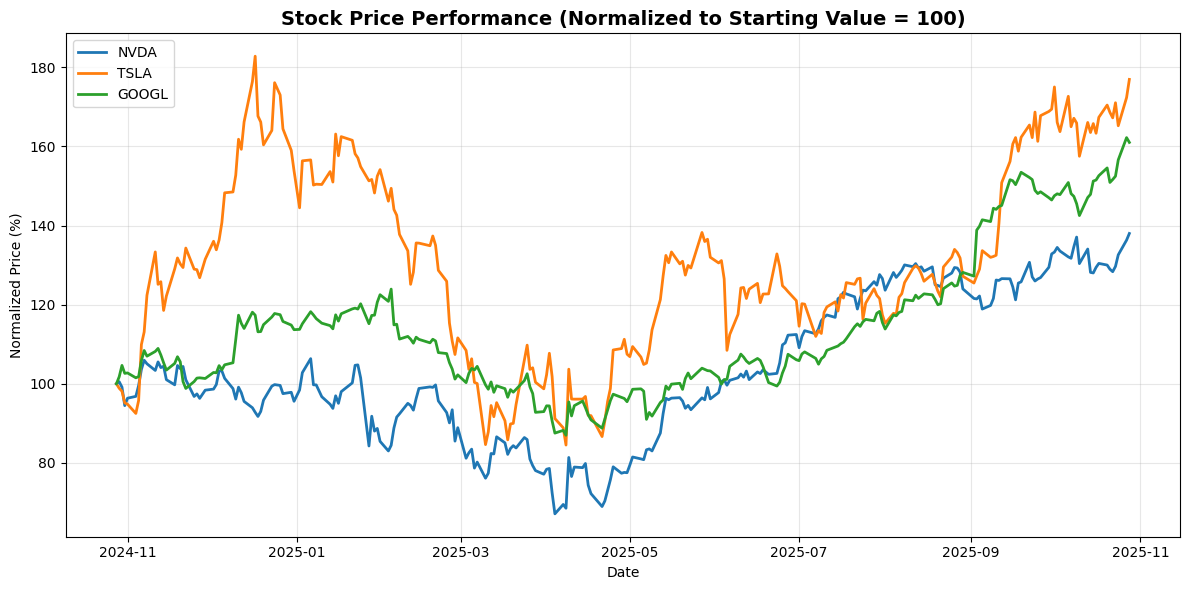


--- Summary Statistics ---

NVDA:
  Time Period: 2024-10-28 to 2025-10-28
  Trading Days: 251
  Missing Values: 0
  Price Range: $94.30 - $193.85
  Starting Price: $140.48
  Ending Price: $193.85
  Total Return: +37.99%

TSLA:
  Time Period: 2024-10-28 to 2025-10-28
  Trading Days: 251
  Missing Values: 0
  Price Range: $221.86 - $479.86
  Starting Price: $262.51
  Ending Price: $464.47
  Total Return: +76.93%

GOOGL:
  Time Period: 2024-10-28 to 2025-10-28
  Trading Days: 251
  Missing Values: 0
  Price Range: $144.40 - $269.27
  Starting Price: $165.99
  Ending Price: $267.26
  Total Return: +61.01%


In [170]:
# Creates a normalized copy for visualization
normalized_stocks = pd.DataFrame()
for ticker, data in stock_data.items():
    normalized_stocks[ticker] = (data['Close'] / data['Close'].iloc[0]) * 100

# Plots normalized stock performance
plt.figure(figsize=(12, 6))
for ticker in normalized_stocks.columns:
    plt.plot(normalized_stocks.index, normalized_stocks[ticker], label=ticker, linewidth=2)

plt.title('Stock Price Performance (Normalized to Starting Value = 100)', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Price (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display summary statistics for each stock
print("\n--- Summary Statistics ---")
for ticker, data in stock_data.items():
    print(f"\n{ticker}:")
    print(f"  Time Period: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")
    print(f"  Trading Days: {len(data)}")
    print(f"  Missing Values: {data.isnull().sum().sum()}")
    print(f"  Price Range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")
    print(f"  Starting Price: ${data['Close'].iloc[0]:.2f}")
    print(f"  Ending Price: ${data['Close'].iloc[-1]:.2f}")
    total_return = ((data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0]) * 100
    print(f"  Total Return: {total_return:+.2f}%")

**Initial Observations:**
- **Volatility Comparison**  
  The normalized plot clearly shows the different volatility profiles, with TSLA exhibiting the largest swings and GOOGL appearing most stable, confirming our initial stock selection rationale.
- **Performance Divergence**  
  The stocks show distinct performance patterns over the year, with significant divergence in returns. This variation is ideal for testing our hypothesis, as we have different "signals" to analyze.
- **Data Quality**  
  All three stocks show complete data with no missing values and consistent trading days, providing a solid foundation for analysis.

#### 4.3.2 Reddit Data Composition & Quality

Next, we explore the structure and distribution of the Reddit data. This helps us understand the volume, source, and potential quality issues of our sentiment data.

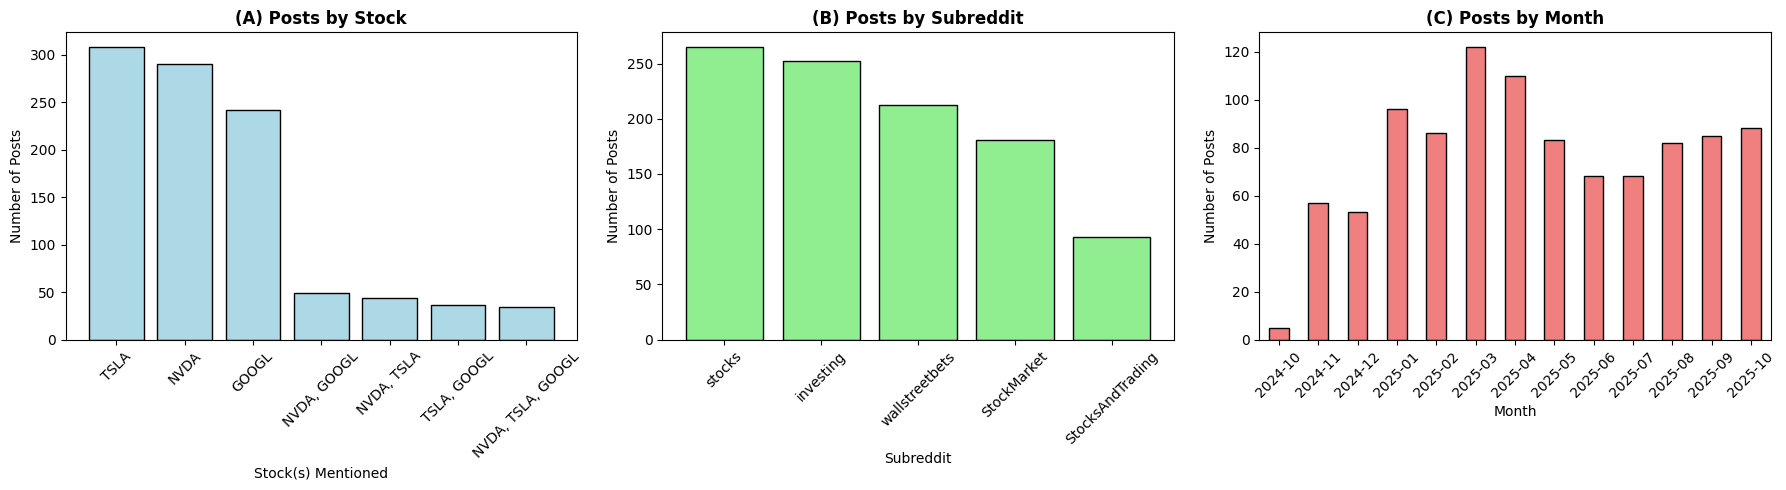

--- General Statistics ---
   Total Posts Collected: 1003
   Date Range: 2024-10-29 to 2025-10-28
   Posts with Empty Content: 165 (16.5%)

--- Posts by Stock Analysis (A) ---
   Single-stock posts: 840 (83.7%)
   Multi-stock posts: 163 (16.3%)

--- Posts by Subreddit Analysis (B) ---
   Posts per subreddit: moderately skewed (-0.732) -> median = 212.00
   Most active subreddit: r/stocks (265 posts)
   Least active subreddit: r/StocksAndTrading (93 posts)

--- Posts by Month Analysis (C) ---
   Posts per month: moderately skewed (-0.936) -> median = 83.0
   Month with most posts: 2025-03 (122 posts)
   Month with fewest posts: 2024-10 (5 posts)


In [184]:
# Create a new figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Raw post distribution by stock
stock_counts = reddit_posts['stock'].value_counts()
axes[0].bar(stock_counts.index, stock_counts.values, color='lightblue', edgecolor='black')
axes[0].set_title('(A) Posts by Stock', fontweight='bold')
axes[0].set_xlabel('Stock(s) Mentioned')
axes[0].set_ylabel('Number of Posts')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Posts by subreddit
subreddit_counts = reddit_posts['subreddit'].value_counts()
axes[1].bar(subreddit_counts.index, subreddit_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title('(B) Posts by Subreddit', fontweight='bold')
axes[1].set_xlabel('Subreddit')
axes[1].set_ylabel('Number of Posts')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Posts per month
month_counts = reddit_posts['datetime'].dt.to_period('M').value_counts().sort_index()
month_counts.plot(kind='bar', ax=axes[2], color='lightcoral', edgecolor='black')
axes[2].set_title('(C) Posts by Month', fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Posts')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Text-based statistics (unchanged, just remove the subreddit part)
print("--- General Statistics ---")
print(f"   Total Posts Collected: {len(reddit_posts)}")
print(f"   Date Range: {reddit_posts['datetime'].min().strftime('%Y-%m-%d')} to {reddit_posts['datetime'].max().strftime('%Y-%m-%d')}")
print(f"   Posts with Empty Content: {reddit_posts['content'].isna().sum()} ({reddit_posts['content'].isna().sum()/len(reddit_posts)*100:.1f}%)")

print("\n--- Posts by Stock Analysis (A) ---")
single_stock_posts = sum(1 for stock in reddit_posts['stock'] if ', ' not in stock)
multi_stock_posts = len(reddit_posts) - single_stock_posts
print(f"   Single-stock posts: {single_stock_posts} ({single_stock_posts/len(reddit_posts)*100:.1f}%)")
print(f"   Multi-stock posts: {multi_stock_posts} ({multi_stock_posts/len(reddit_posts)*100:.1f}%)")

print("\n--- Posts by Subreddit Analysis (B) ---")
posts_per_subreddit, method_used = calculate_middle(subreddit_counts.values)
print(f"   Posts per subreddit: {method_used} = {posts_per_subreddit:.2f}")
print(f"   Most active subreddit: r/{subreddit_counts.index[0]} ({subreddit_counts.iloc[0]} posts)")
print(f"   Least active subreddit: r/{subreddit_counts.index[-1]} ({subreddit_counts.iloc[-1]} posts)")

print("\n--- Posts by Month Analysis (C) ---")
central_tendency, method_used = calculate_middle(month_counts.values)
print(f"   Posts per month: {method_used} = {central_tendency:.1f}")
print(f"   Month with most posts: {posts_per_month.idxmax()} ({posts_per_month.max()} posts)")
print(f"   Month with fewest posts: {posts_per_month.idxmin()} ({posts_per_month.min()} posts)")

**Identified Data Quality Issues:**

1. **Multi-Stock Posts**  
   16.3% of posts (163/1003) mention multiple stocks.

2. **Temporal Skew**  
   Post volume per month is moderately skewed, with October 2024 having only 5 posts and March 2025 having 122 posts.

3. **Subreddit Skew**  
   Post distribution across subreddits is moderately skewed, with r/stocks (265 posts) being most active and r/StocksAndTrading (93 posts) least active.

4. **Content Gaps**  
   16.5% of posts lack body content, relying solely on titles for sentiment.

*These issues will be addressed in the Data Cleaning section below.*

#### 4.3.3 Temporal Alignment Check

Finally, we verify that our stock price and Reddit sentiment data cover overlapping time periods, which is essential for a valid correlation analysis.

In [172]:
stock_start = min(data.index.min() for data in stock_data.values())
stock_end = max(data.index.max() for data in stock_data.values())

if not reddit_posts.empty:
    print("=== TEMPORAL ALIGNMENT CHECK ===\n")

    overlap_start = max(stock_start, reddit_start)
    overlap_end = min(stock_end, reddit_end)
    overlap_days = (overlap_end - overlap_start).days + 1
    
    print("COVERAGE SUMMARY")
    print(f"Stock Data:      {stock_start.strftime('%Y-%m-%d')} to {stock_end.strftime('%Y-%m-%d')} ({len(stock_data['NVDA'])} trading days)")
    print(f"Reddit Data:     {reddit_start.strftime('%Y-%m-%d')} to {reddit_end.strftime('%Y-%m-%d')}")
    print(f"Overlap Period:  {overlap_start.strftime('%Y-%m-%d')} to {overlap_end.strftime('%Y-%m-%d')}")
    print(f"Overlap Duration: {overlap_days} days ({overlap_days/7:.1f} weeks)")
    
    # Calculate coverage metrics
    total_possible_days = (max(stock_end, reddit_end) - min(stock_start, reddit_start)).days + 1
    coverage_percentage = (overlap_days / total_possible_days) * 100
    
    print("\nALIGNMENT METRICS")
    print(f"Temporal Coverage: {coverage_percentage:.1f}% of total period")
    print(f"Weekly Data Points: {overlap_days//7} full weeks available")
else:
    print("No Reddit data available for alignment check")

=== TEMPORAL ALIGNMENT CHECK ===

COVERAGE SUMMARY
Stock Data:      2024-10-28 to 2025-10-28 (251 trading days)
Reddit Data:     2024-10-29 to 2025-10-28
Overlap Period:  2024-10-29 to 2025-10-28
Overlap Duration: 364 days (52.0 weeks)

ALIGNMENT METRICS
Temporal Coverage: 99.5% of total period
Weekly Data Points: 52 full weeks available


**Alignment Assessment:**

- **Excellent Temporal Coverage:**  
  With 99.5% coverage and exactly 52 full weeks of overlapping data, we have a complete year of synchronized observations for analysis.

- **Ideal for Weekly Aggregation:**  
  The perfect 52-week overlap aligns exactly with our methodological choice of weekly aggregation, providing one data point for each week of the year.

- **Minimal Data Loss:**  
  The 1-day misalignment at the start (Oct 28 vs Oct 29) is negligible and will not impact our weekly analysis.

## 5. Data Preprocessing & Feature Engineering

### 5.1 Addressing Data Quality Issues

Based on the initial inspection, the following data quality issues were identified and will be addressed:

* **Issue 1: Multi-Stock Posts**  
  Finding: 163 posts (16%) mention multiple stocks, creating ambiguous sentiment attribution.  
  Solution: These posts will be duplicated for each mentioned stock to ensure clean stock-specific analysis.  
  Limitation: This approach assumes sentiment applies equally to all mentioned stocks, which may not reflect nuanced discussions where stocks are mentioned with different sentiment valences (e.g., "I love NVDA but hate TSLA"). This is a noted constraint of our sentiment aggregation methodology.

* **Issue 2: Empty Content**  
  Finding: 165 posts (16%) have empty content.  
  Solution: The post title will be used as the primary content for sentiment analysis, as titles typically contain the core sentiment.

* **Issue 3: Temporal Volatility in Post Volume**  
  Finding: Post volume shows moderate volatility, with particularly low volume in October 2024 (5 posts).  
  Solution: Weekly aggregation will smooth this volatility. The impact of low-volume periods on weekly sentiment averages will be considered during analysis.

### 5.2 Data Cleaning

In [173]:
# Create a copy for processing
reddit_clean = reddit_posts.copy()
print(f"Initial dataset: {len(reddit_clean)} posts")

# 1. Handle Multi-Stock Posts
print("\n1. Processing multi-stock posts...")

expanded_posts = []
for i, row in reddit_clean.iterrows():
    if ', ' in row['stock']:
        # Split and clean stock symbols
        multiple_stocks = [s.strip() for s in row['stock'].split(', ')]
        for stock in multiple_stocks:
            new_row = row.copy()
            new_row['stock'] = stock
            new_row['was_multi_stock'] = True  # Flag for tracking
            expanded_posts.append(new_row)
    else:
        row['was_multi_stock'] = False  # Flag for tracking
        expanded_posts.append(row)

reddit_clean = pd.DataFrame(expanded_posts).reset_index(drop=True)
print(f"   After expansion: {len(reddit_clean)} individual stock-mentions")

# 2. Handle Empty Content
print("\n2. Handling empty content...")

reddit_clean['content_clean'] = reddit_clean['content'].fillna('')
reddit_clean['text_for_analysis'] = reddit_clean['title'] + ' ' + reddit_clean['content_clean']
reddit_clean['text_for_analysis'] = reddit_clean['text_for_analysis'].str.strip()

# Check for completely empty text
empty_text_after = (reddit_clean['text_for_analysis'].str.len() == 0).sum()
print(f"   Posts with no text after cleaning: {empty_text_after}")

print(f"\nData cleaning completed")

Initial dataset: 1003 posts

1. Processing multi-stock posts...
   After expansion: 1200 individual stock-mentions

2. Handling empty content...
   Posts with no text after cleaning: 0

Data cleaning completed


#### 5.2.1 Data Cleaning Validation

=== DATA CLEANING VALIDATION ===



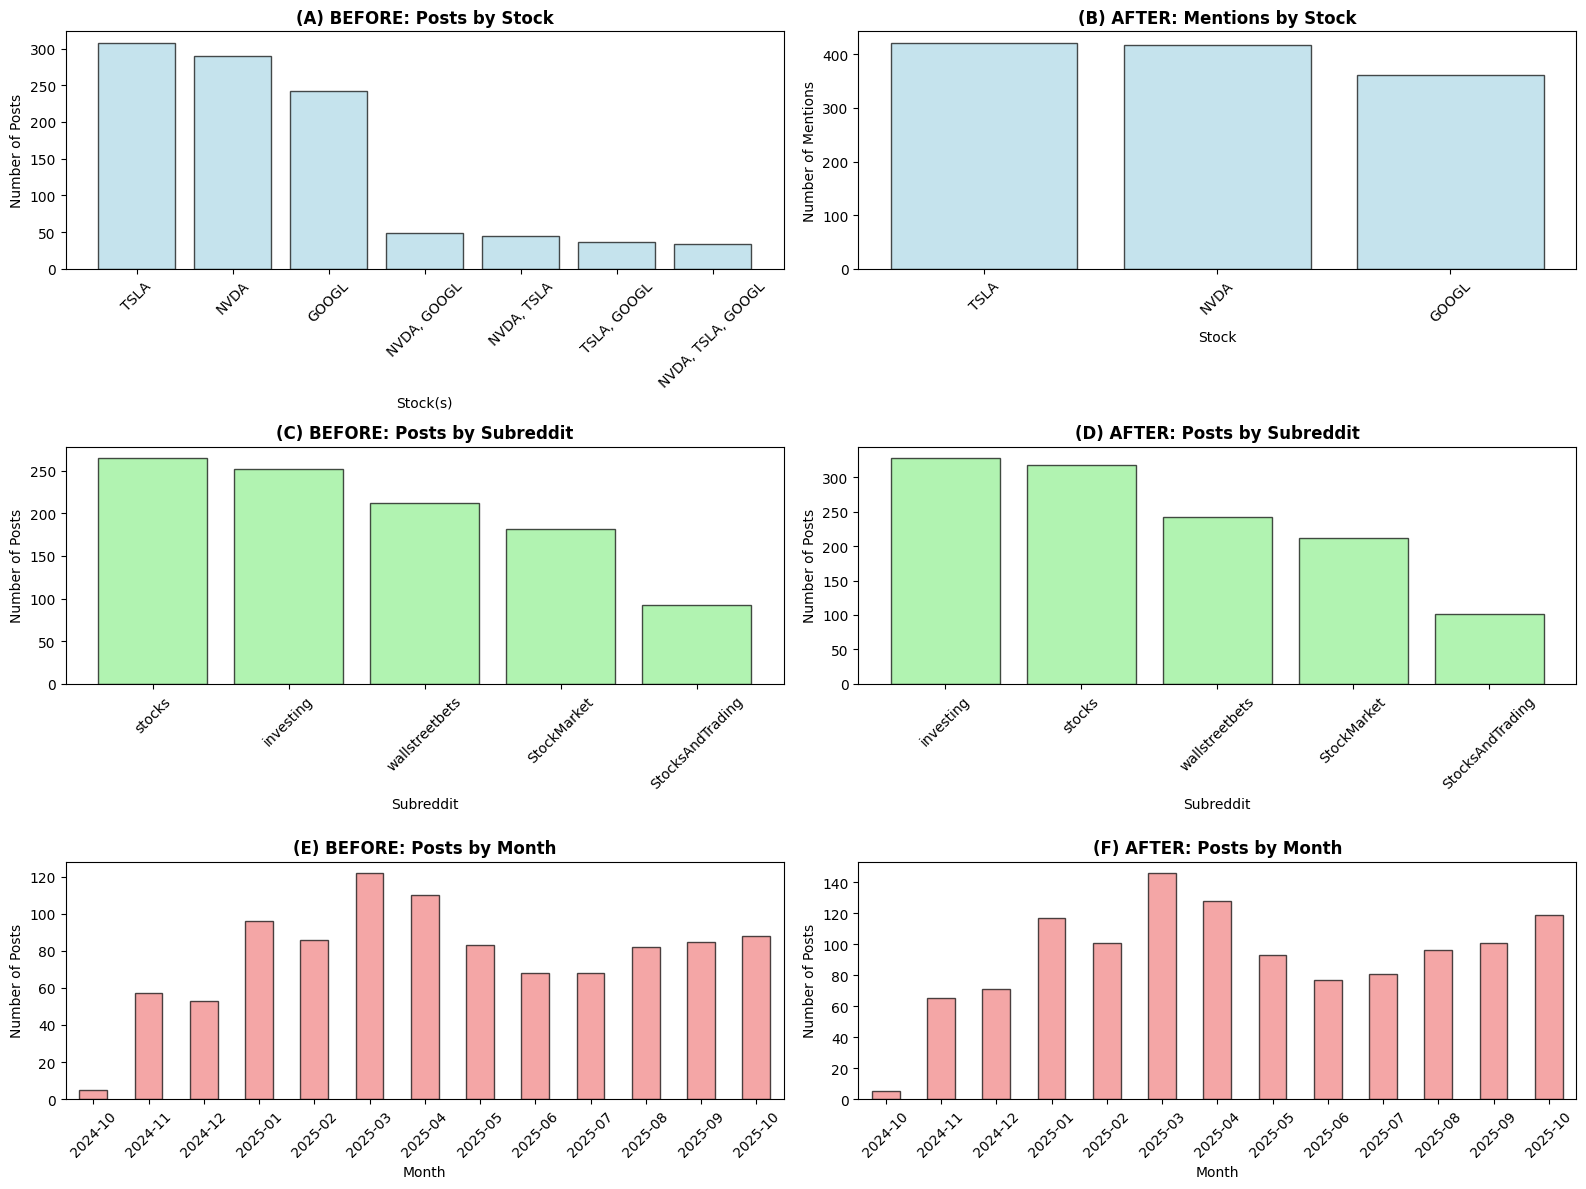

=== DISTRIBUTION CHANGES ===

STOCK DISTRIBUTION (A/B):
   Posts:  1200
   (BEFORE: 1003 posts, 163 multi-stock posts)
   -> 197 posts increase

SUBREDDIT DISTRIBUTION (C/D):
   Posts per Subreddit: moderately skewed (-0.551) -> median 242.0
   (BEFORE moderately skewed (-0.732) -> median 212.0)
   Most active: r/investing (328 posts)
   (BEFORE: r/stocks (265 posts))
   Least active: r/StocksAndTrading (102 posts)
   (BEFORE: r/StocksAndTrading (93 posts))

TEMPORAL DISTRIBUTION (E/F):
   Posts per Month: moderately skewed (-0.928) -> median 96.0
   (BEFORE moderately skewed (-0.936) -> median 83.0)
   Month with most posts: 2025-03 (146 posts)
   (BEFORE: 2025-03 (122 posts)
   Month with fewest posts: 2024-10 (5 posts)
   (BEFORE: 2025-03 (122 posts))


In [199]:
# 5.2.1 Data Cleaning Validation
print("=== DATA CLEANING VALIDATION ===\n")

# Create comparison figure - 3 rows, 2 columns
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Calculate all statistics first
stock_counts_before = reddit_posts['stock'].value_counts()
stock_counts_after = reddit_clean['stock'].value_counts()
subreddit_counts_before = reddit_posts['subreddit'].value_counts()
subreddit_counts_after = reddit_clean['subreddit'].value_counts()
month_counts_before = reddit_posts['datetime'].dt.to_period('M').value_counts().sort_index()
month_counts_after = reddit_clean['datetime'].dt.to_period('M').value_counts().sort_index()

# Row 1: Stock Distribution
# Left: BEFORE
axes[0,0].bar(stock_counts_before.index, stock_counts_before.values, color='lightblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title('(A) BEFORE: Posts by Stock', fontweight='bold')
axes[0,0].set_xlabel('Stock(s)')
axes[0,0].set_ylabel('Number of Posts')
axes[0,0].tick_params(axis='x', rotation=45)

# Right: AFTER
axes[0,1].bar(stock_counts_after.index, cleaned_stock_counts.values, color='lightblue', edgecolor='black', alpha=0.7)
axes[0,1].set_title('(B) AFTER: Mentions by Stock', fontweight='bold')
axes[0,1].set_xlabel('Stock')
axes[0,1].set_ylabel('Number of Mentions')
axes[0,1].tick_params(axis='x', rotation=45)

# Row 2: Subreddit Distribution
# Left: BEFORE
axes[1,0].bar(subreddit_counts_before.index, subreddit_counts_before.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1,0].set_title('(C) BEFORE: Posts by Subreddit', fontweight='bold')
axes[1,0].set_xlabel('Subreddit')
axes[1,0].set_ylabel('Number of Posts')
axes[1,0].tick_params(axis='x', rotation=45)

# Right: AFTER
axes[1,1].bar(subreddit_counts_after.index, subreddit_counts_after.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1,1].set_title('(D) AFTER: Posts by Subreddit', fontweight='bold')
axes[1,1].set_xlabel('Subreddit')
axes[1,1].set_ylabel('Number of Posts')
axes[1,1].tick_params(axis='x', rotation=45)

# Row 3: Temporal Distribution
# Left: BEFORE
month_counts_before.plot(kind='bar', ax=axes[2,0], color='lightcoral', edgecolor='black', alpha=0.7)
axes[2,0].set_title('(E) BEFORE: Posts by Month', fontweight='bold')
axes[2,0].set_xlabel('Month')
axes[2,0].set_ylabel('Number of Posts')
axes[2,0].tick_params(axis='x', rotation=45)

# Right: AFTER
month_counts_after.plot(kind='bar', ax=axes[2,1], color='lightcoral', edgecolor='black', alpha=0.7)
axes[2,1].set_title('(F) AFTER: Posts by Month', fontweight='bold')
axes[2,1].set_xlabel('Month')
axes[2,1].set_ylabel('Number of Posts')
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Distribution changes below each plot category
print("=== DISTRIBUTION CHANGES ===\n")

print("STOCK DISTRIBUTION (A/B):")
multi_stock_before = len([s for s in reddit_posts['stock'] if ', ' in s])
print(f"   Posts:  {len(reddit_clean)}")
print(f"   (BEFORE: {len(reddit_posts)} posts, {multi_stock_before} multi-stock posts)")
print(f"   -> {len(reddit_clean) - len(reddit_posts)} posts increase")

print("\nSUBREDDIT DISTRIBUTION (C/D):")
posts_per_subreddit_before, method_used_sub_b = calculate_middle(subreddit_counts_before)
posts_per_subreddit_after, method_used_sub_a = calculate_middle(subreddit_counts_after)
print(f"   Posts per Subreddit: {method_used_sub_a} {posts_per_subreddit_after}")
print(f"   (BEFORE {method_used_sub_b} {posts_per_subreddit_before})")
print(f"   Most active: r/{subreddit_counts_after.index[0]} ({subreddit_counts_after.iloc[0]} posts)")
print(f"   (BEFORE: r/{subreddit_counts_before.index[0]} ({subreddit_counts_before.iloc[0]} posts))")
print(f"   Least active: r/{subreddit_counts_after.index[-1]} ({subreddit_counts_after.iloc[-1]} posts)")
print(f"   (BEFORE: r/{subreddit_counts_before.index[-1]} ({subreddit_counts_before.iloc[-1]} posts))")

print("\nTEMPORAL DISTRIBUTION (E/F):")
posts_per_month_before, method_used_month_b = calculate_middle(month_counts_before.values)
posts_per_month_after, method_used_month_a = calculate_middle(month_counts_after.values)
print(f"   Posts per Month: {method_used_month_a} {posts_per_month_after}")
print(f"   (BEFORE {method_used_month_b} {posts_per_month_before})")
print(f"   Month with most posts: {month_counts_after.idxmax()} ({month_counts_after.max()} posts)")
print(f"   (BEFORE: {month_counts_before.idxmax()} ({month_counts_before.max()} posts)")
print(f"   Month with fewest posts: {month_counts_after.idxmin()} ({month_counts_after.min()} posts)")
print(f"   (BEFORE: {month_counts_before.idxmax()} ({month_counts_before.max()} posts))")

#### 4.4.3 Feature Engineering

This section creates the analytical features needed for correlation analysis:

**Sentiment Analysis Features**
- Calculate sentiment scores using both TextBlob and VADER as specified in the methodology
- Generate categorical sentiment labels (positive/neutral/negative) for distribution analysis
- Create combined sentiment score for robust measurement
- Add `week_ending` temporal feature (Friday-based) for weekly aggregation alignment

**Stock Return Features** 
- Calculate daily percentage returns for supplementary analysis
- Calculate weekly percentage returns for primary analysis (aligned with our temporal aggregation strategy)
- Add `week_ending` dates to returns data for consistent merging
- Prepare returns data for merging with sentiment aggregates

**Temporal Alignment Features**
- Friday-based week ending dates for both sentiment and returns data
- Consistent time periods for correlation analysis
- Ready for weekly aggregation in the next section

In [61]:
print("Starting feature engineering...")

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
print("✓ Sentiment analyzers initialized")

def analyze_sentiment(text):
    """Sentiment analysis using TextBlob and VADER."""
    # Handle missing/invalid text robustly
    if not text or pd.isna(text) or text in ['[removed]', '[deleted]', '']:
        return {
            'textblob_score': 0.0,
            'vader_score': 0.0,
            'combined_score': 0.0,
            'sentiment_label': 'neutral',
            'vader_details': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
        }
    
    text = str(text).strip()
    
    # VADER sentiment analysis
    try:
        vader_scores = vader_analyzer.polarity_scores(text)
        vader_compound = vader_scores['compound']
    except Exception as e:
        print(f"VADER analysis failed for text: {text[:100]}... Error: {e}")
        vader_scores = {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
        vader_compound = 0.0
    
    # TextBlob sentiment analysis
    try:
        blob = TextBlob(text)
        textblob_polarity = blob.sentiment.polarity
        textblob_subjectivity = blob.sentiment.subjectivity
    except Exception as e:
        print(f"TextBlob analysis failed for text: {text[:100]}... Error: {e}")
        textblob_polarity = 0.0
        textblob_subjectivity = 0.0
    
    # Combined score (equal weighting)
    combined_score = (vader_compound + textblob_polarity) / 2
    
    # Research-based threshold selection
    # Common thresholds: > 0.05 for positive, < -0.05 for negative
    if combined_score > 0.05:
        sentiment_label = 'positive'
    elif combined_score < -0.05:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
        
    return {
        'textblob_score': textblob_polarity,
        'vader_score': vader_compound,
        'combined_score': combined_score,
        'sentiment_label': sentiment_label,
        'textblob_subjectivity': textblob_subjectivity,
        'vader_details': vader_scores
    }

print("Applying sentiment analysis...")

# Apply sentiment analysis and expand results into separate columns
sentiment_results = reddit_clean['text_for_analysis'].apply(analyze_sentiment)
sentiment_df = pd.json_normalize(sentiment_results)
reddit_with_sentiment = reddit_clean.assign(**sentiment_df.to_dict('series'))

print("✓ Sentiment analysis completed")

# --- Add Temporal Features for Weekly Analysis ---
print("\nAdding temporal features for weekly aggregation...")

# Add Friday-based week ending for alignment with stock data
reddit_with_sentiment['week_ending'] = reddit_with_sentiment['datetime'] + pd.tseries.offsets.Week(weekday=4)
reddit_with_sentiment['week_ending'] = reddit_with_sentiment['week_ending'].dt.date

print(f"Added week_ending feature for {reddit_with_sentiment['week_ending'].nunique()} unique weeks")

# --- Stock Returns Calculation ---
print("\nCalculating stock returns...")

def calculate_stock_returns(stock_data):
    """Calculate daily returns and weekly returns for correlation analysis"""
    returns_data = {}
    
    for ticker, data in stock_data.items():
        df = data.copy()
        
        # Daily returns
        df['daily_return'] = df['Close'].pct_change()
        
        # Weekly returns
        # Resample to weekly frequency using Friday as week end
        weekly_data = df.resample('W-FRI').last()
        weekly_data['weekly_return'] = weekly_data['Close'].pct_change()
        
        # Add week_ending date for merging
        weekly_data['week_ending'] = weekly_data.index.date
        
        returns_data[ticker] = {
            'daily': df,
            'weekly': weekly_data
        }
        
        print(f"  {ticker}: {len(weekly_data)} weeks of return data")
    
    return returns_data

# Calculate returns for all stocks
stock_returns = calculate_stock_returns(stock_data)
print("✓ Stock returns calculated with week_ending dates")

print("\nFeature engineering completed - all temporal features added")

Starting feature engineering...
✓ Sentiment analyzers initialized
Applying sentiment analysis...
✓ Sentiment analysis completed

Adding temporal features for weekly aggregation...
Added week_ending feature for 53 unique weeks

Calculating stock returns...
  NVDA: 53 weeks of return data
  TSLA: 53 weeks of return data
  GOOGL: 53 weeks of return data
✓ Stock returns calculated with week_ending dates

✅ Feature engineering completed - all temporal features added


### 4.5 Dataset Merging & Final Validation
#### 4.5.1 Feature Validation

In [75]:
print("Reddit Data Validation:")
print(f"Total posts: {len(reddit_with_sentiment)}")
print(f"Date range: {reddit_with_sentiment['datetime'].min().date()} to {reddit_with_sentiment['datetime'].max().date()}")
print("Posts by stock:")
stock_counts = reddit_with_sentiment['stock'].value_counts()
for stock, count in stock_counts.items():
    print(f"  {stock}: {count} posts")

print("\nPosts by subreddit:")
subreddit_counts = reddit_with_sentiment['category'].value_counts().head()
for subreddit, count in subreddit_counts.items():
    percentage = (count / len(reddit_with_sentiment)) * 100
    print(f"  r/{subreddit}: {count} posts ({percentage:.1f}%)")

print("\nData Quality Checks:")
print(f"  Posts with empty original content: {reddit_with_sentiment['content'].isna().sum()}")
print(f"  Posts with empty analysis text: {(reddit_with_sentiment['text_for_analysis'].str.len() == 0).sum()}")
print(f"  Duplicate post IDs: {reddit_with_sentiment['id'].duplicated().sum()}")

print("\nTemporal Features Validation:")
print(f"  Unique weeks in data: {reddit_with_sentiment['week_ending'].nunique()}")
print(f"  Week ending range: {reddit_with_sentiment['week_ending'].min()} to {reddit_with_sentiment['week_ending'].max()}")
week_endings = reddit_with_sentiment['week_ending'].value_counts()
posts_per_week, measure_used = calculate_middle(week_endings)
print(f"  Posts per week: {measure_used}: {posts_per_week:.2f}")

print("\nSentiment Analysis Validation:")
print("Sentiment distribution:")
sentiment_dist = reddit_with_sentiment['sentiment_label'].value_counts(normalize=True)
for label, proportion in sentiment_dist.items():
    print(f"  {label}: {proportion:.3f} ({int(proportion * len(reddit_with_sentiment))} posts)")

print("\nSentiment Score Distribution Analysis:")

for method in ['textblob_score', 'vader_score', 'combined_score']:
    scores = reddit_with_sentiment[method].dropna()
    central_tendency, measure_used = calculate_middle(scores)
    
    print(f"  {method}: {measure_used}: {central_tendency:.3f}")

print("\nMethod Correlation:")
correlation = reddit_with_sentiment['textblob_score'].corr(reddit_with_sentiment['vader_score'])
print(f"  TextBlob vs VADER correlation: {correlation:.3f}")

print("\nStock Data Validation:")
for ticker, returns_data in stock_returns.items():
    daily_data = returns_data['daily']
    weekly_data = returns_data['weekly']
    print(f"  {ticker}:")
    print(f"    Daily observations: {len(daily_data)}")
    print(f"    Weekly observations: {len(weekly_data)}")
    print(f"    Date range: {daily_data.index.min().date()} to {daily_data.index.max().date()}")
    print(f"    Missing returns: {daily_data['daily_return'].isna().sum()} daily, {weekly_data['weekly_return'].isna().sum()} weekly")
    print(f"    Week ending dates available: {'week_ending' in weekly_data.columns}")

print("\n✅ All temporal features validated and ready for merging")

Reddit Data Validation:
Total posts: 1200
Date range: 2024-10-29 to 2025-10-28
Posts by stock:
  TSLA: 422 posts
  NVDA: 417 posts
  GOOGL: 361 posts

Posts by subreddit:
  r/investing: 328 posts (27.3%)
  r/stocks: 317 posts (26.4%)
  r/wallstreetbets: 242 posts (20.2%)
  r/StockMarket: 211 posts (17.6%)
  r/StocksAndTrading: 102 posts (8.5%)

Data Quality Checks:
  Posts with empty original content: 167
  Posts with empty analysis text: 0
  Duplicate post IDs: 197

Temporal Features Validation:
  Unique weeks in data: 53
  Week ending range: 2024-11-01 to 2025-10-31
  Posts per week: fairly symmetric -> mean: 22.64

Sentiment Analysis Validation:
Sentiment distribution:
  positive: 0.687 (824 posts)
  negative: 0.233 (279 posts)
  neutral: 0.081 (96 posts)

Sentiment Score Distribution Analysis:
  textblob_score: fairly symmetric -> mean: 0.076
  vader_score: moderately skewed -> median: 0.674
  combined_score: moderately skewed -> median: 0.368

Method Correlation:
  TextBlob vs VAD

#### 4.5.1a Validation Insights & Implications

Based on the feature validation, several important patterns emerge:

**A. Temporal & Data Structure**
- **Complete Year Coverage**: 53 weeks of data from 2024-11-01 to 2025-10-31, perfectly aligned with stock data
- **Balanced Weekly Distribution**: Posts are evenly distributed across weeks (mean: 22.6 posts/week, symmetric distribution)
- **Stock Representation**: Well-balanced across TSLA (35%), NVDA (35%), and GOOGL (30%)

**B. Sentiment Distribution Characteristics**
- **Strong Positive Bias**: 68.7% of posts are positive vs 23.3% negative, indicating overall optimistic Reddit sentiment
- **Methodological Insights**:
  - VADER scores are moderately skewed (median=0.674) vs TextBlob's symmetric distribution (mean=0.076)
  - Combined scores are moderately skewed (median=0.368), supporting median-based analysis
  - Weak correlation (r=0.333) between methods justifies combined approach

**C. Data Quality & Composition**
- **Subreddit Diversity**: Good spread across investing communities, with r/investing (27%) and r/stocks (26%) as primary sources
- **Data Processing**: 
  - 13.9% of posts used titles only due to empty content
  - 16.4% duplicate posts from multi-stock expansion (will be aggregated in weekly analysis)

**D. Implications for Correlation Analysis**
- Weekly aggregation will effectively handle duplicate posts and provide consistent time periods
- Positive sentiment bias may affect correlation strength with stock returns
- Combined sentiment scores with median-based analysis provide robustness against methodological differences
- Complete temporal alignment ensures valid week-to-week comparisons

#### 4.5.2 Data Merging

This section aggregates the sentiment data by week and stock, then merges it with the corresponding weekly stock returns to create the final analysis dataset.

In [76]:
print("1. Aggregating sentiment data by week and stock...")

# Aggregate sentiment by week and stock
weekly_sentiment = reddit_with_sentiment.groupby(['week_ending', 'stock']).agg(
    sentiment_mean=('combined_score', 'mean'),
    post_count=('combined_score', 'count'),
    textblob_mean=('textblob_score', 'mean'),
    vader_mean=('vader_score', 'mean'), 
    dominant_sentiment=('sentiment_label', lambda x: x.value_counts().index[0])
).round(4).reset_index()

print(f"Created weekly sentiment aggregates: {len(weekly_sentiment)} week-stock combinations")

print("\n2. Preparing weekly stock returns...")

# Extract weekly returns for all stocks
weekly_returns_list = []
for ticker, returns_data in stock_returns.items():
    weekly_data = returns_data['weekly'].copy()
    weekly_data['stock'] = ticker
    weekly_returns_list.append(weekly_data[['week_ending', 'stock', 'weekly_return']])

weekly_returns = pd.concat(weekly_returns_list, ignore_index=True)
print(f"Weekly returns data: {len(weekly_returns)} records")

print("\n3. Merging sentiment and returns data...")

# Merge on week_ending and stock
merged_data = pd.merge(
    weekly_sentiment,
    weekly_returns,
    on=['week_ending', 'stock'],
    how='inner'  # Only keep weeks with both sentiment and returns data
)

print(f"Merged dataset: {len(merged_data)} week-stock observations")
print(f"Date range in merged data: {merged_data['week_ending'].min()} to {merged_data['week_ending'].max()}")

print("\n4. Final merged dataset structure:")
print(f"Columns: {merged_data.columns.tolist()}")
print(f"Stocks: {merged_data['stock'].unique()}")
print(f"Total weeks: {merged_data['week_ending'].nunique()}")
print(f"Observations per stock:")
print(merged_data['stock'].value_counts())

print("Data merging completed successfully!")

1. Aggregating sentiment data by week and stock...
Created weekly sentiment aggregates: 158 week-stock combinations

2. Preparing weekly stock returns...
Weekly returns data: 159 records

3. Merging sentiment and returns data...
Merged dataset: 158 week-stock observations
Date range in merged data: 2024-11-01 to 2025-10-31

4. Final merged dataset structure:
Columns: ['week_ending', 'stock', 'sentiment_mean', 'post_count', 'textblob_mean', 'vader_mean', 'dominant_sentiment', 'weekly_return']
Stocks: ['GOOGL' 'TSLA' 'NVDA']
Total weeks: 53
Observations per stock:
stock
GOOGL    53
TSLA     53
NVDA     52
Name: count, dtype: int64
Data merging completed successfully!


#### 4.5.3 Merged Dataset Validation

In [77]:
print("Final Dataset Quality Check:")
print(f"Total observations: {len(merged_data)}")
print(f"Complete cases: {len(merged_data.dropna())}")
print(f"Missing values: {merged_data.isnull().sum().sum()}")

print("\nCoverage Summary:")
print(f"Weeks with data: {merged_data['week_ending'].nunique()}")
print(f"Stocks with complete coverage: {sum(merged_data['stock'].value_counts() >= 52)}/3")

print("\nData Ranges for Analysis:")
print(f"Weekly returns: {merged_data['weekly_return'].min():.3f} to {merged_data['weekly_return'].max():.3f}")
print(f"Sentiment scores: {merged_data['sentiment_mean'].min():.3f} to {merged_data['sentiment_mean'].max():.3f}")
print(f"Posts per week: {merged_data['post_count'].min()} to {merged_data['post_count'].max()}")

print("\n✅ Merged dataset validated - ready for correlation analysis!")

Final Dataset Quality Check:
Total observations: 158
Complete cases: 156
Missing values: 2

Coverage Summary:
Weeks with data: 53
Stocks with complete coverage: 3/3

Data Ranges for Analysis:
Weekly returns: -0.158 to 0.290
Sentiment scores: -0.390 to 0.704
Posts per week: 1 to 31

✅ Merged dataset validated - ready for correlation analysis!
